# Using Neural Networks for Image Classification

This project uses a set of images of people with or without glass. Its goal is to develop a classifier for classifying these two types of images using the artificial neural network (ANN) method.

In [1]:
import os
import random
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from math import sqrt
import time as tm

The first two functions are assigned to work with the PGM image format. The first one (read_pgm) receives a PGM file as input and returns a list containing its pixels. The second function (read_data) uses the first one to make a dataset whose instances are the list of pixels of the images.

In [2]:
def read_pgm (pgmf):
    header = pgmf.readline()
    assert header[:2] == b'P5'
    header = pgmf.readline()
    (width, height) = [int(i) for i in header.split()]
    header = pgmf.readline()
    depth = int(header.split()[0])
    assert depth <= 65535

    raster = []
    for i in range(height):
        for j in range(width):
            raster.append(float(ord(pgmf.read(1))))
    return raster

def read_data (data_path, dataset, data_labels):
    mylist = os.listdir(data_path)
    for j in mylist:
        mymylist = os.listdir(data_path + '\\' + j)
        for i in mymylist:
            f = open(data_path + '\\' + j + '\\' + i, 'rb')
            im = read_pgm(f)
            f.close()
            dataset.append(im)
            if i.find("sunglasses") == -1:
                data_labels.append(-1)
            else:
                data_labels.append(1)

                
data_path = r"D:\Takeen\University\6- Data Mining\Homework\HW2\faces_4"
dataset = []
data_labels = []
read_data(data_path, dataset, data_labels)

## Part1
The next part of the code is where classification begins. In this part, the "devide_into_test_and_train" function is implemented that gets the primary dataset and labels and divides it into training set and test set. The rate of dataset instance that should go to testset is given to the function using the test_perc variable. The last two lines run this function with test_perc = 0.3 and return the rate of positive and negative instances in each set.

In [3]:
### part1

def devide_into_test_and_train (dataset, data_labels, test_perc, show_distribution):
    trainingset = dataset[:]
    training_labels = data_labels[:]
    testset = []
    test_labels = []
    
    l = len(trainingset)
    test_size = int(test_perc * l)

    for i in range(test_size):
        r = random.randint(0, l-1)
        testset.append(trainingset.pop(r))
        test_labels.append(training_labels.pop(r))
        l -= 1
    
    if show_distribution:
        print(f'training set --> 1: {training_labels.count(1)/l} / -1: {training_labels.count(-1)/l}')
        print(f'test set --> 1: {test_labels.count(1)/test_size} / -1: {test_labels.count(-1)/test_size}')
    
    return trainingset, training_labels, testset, test_labels
    
test_perc = 0.3
trainingset, training_labels, testset, test_labels = devide_into_test_and_train(dataset, data_labels, test_perc, True)

training set --> 1: 0.5331807780320366 / -1: 0.4668192219679634
test set --> 1: 0.41711229946524064 / -1: 0.5828877005347594


## Part2
The second part of the code builds a classifier using the "build_classifier" function operating the MLPClassifier function from the Scikit-learn library which trains neural networks using the backpropagation method. The number of nodes in each layer and also the learning rate are passed to build_classifier as parameter. Later, We will explain the reasons why such parameters are chosen for running the function.

In [4]:
### part2

def build_classifier (trainingset, training_labels, hidden_layers, learning_rate = None):
    if learning_rate == None:
        clf = MLPClassifier(solver='sgd', hidden_layer_sizes=hidden_layers, max_iter=2000)
    else:
        clf = MLPClassifier(solver='sgd', hidden_layer_sizes=hidden_layers, max_iter=2000, learning_rate_init=learning_rate)
    clf.fit(trainingset, training_labels)
    return clf

classifier = build_classifier(trainingset, training_labels, (110, 110, 110), 0.001)

## Part 3
This part focuses on finding the error of the classification model. To do that, we implement and run the function "report_error". This function gets the classifier and checks if the result for each instance (in training or test set) matches the actual label. Based on the number of good guesses in the training set and the test set, it calculates training error rate and test error rate.

In [5]:
### part3

def report_error (clf, trainingset, training_labels, testset, test_labels):
    # TRAINING ERROR
    result = list(clf.predict(trainingset))
    count1 = 0
    l1 = len(trainingset)
    for i in range(l1):
        if training_labels[i] == result[i]:
            count1 += 1

    # TEST ERROR
    result = list(clf.predict(testset))
    count2 = 0
    l2 = len(testset)
    for i in range(l2):
        if test_labels[i] == result[i]:
            count2 += 1
    
    return 1-count1/l1, 1-count2/l2

tr_err, test_err = report_error(classifier, trainingset, training_labels, testset, test_labels)
            
print("training error rate = \t", tr_err)
print("test error rate = \t", test_err)

training error rate = 	 0.0
test error rate = 	 0.11229946524064172


## Part 4
The validate function in this part of the code is designed to build several neural networks with three hidden layers (with equal number of nodes in each layer that is given to the function using variable "node_in_each_layer"). For each number of nodes, the function conduct ten experiments with ten different learning rates, which is initially equal to 0.01 and every time, it is divided by $\sqrt[4]{10}$. In each experiment, the function makes 15 different classifiers (based on 15 dissimilar partitions of dataset) and saves the averages of these factors:
* training error
* test error
* the number of iteration (untill the optimization converge)
* the needed time to build the classifier

At the end, three plots are drawn to show the change of these factors during the experiments. Each plot displays:
1. training error(blue), test error(yellow), the difference between traning and test errors(green)
2. average(blue) and maximum(yellow) iterations needed to train classifier
3. average(blue) and maximum(yellow) time needed to train classifier (in seconds)

After the code of validate function, it is used on neural networks with 2, 4, 10, and 50 nodes in each hidden layer.

In [6]:
### part4

def validate (dataset, data_labels, node_in_each_layer):
    iter_num = 10
    init_learning_rate = 0.01
    init_l = [i for i in range(iter_num)]
    tr_err_l = []
    test_err_l = []
    iter_num_l = []
    max_iter_num_l = []
    time_l = []
    max_time_l = []
    

    x = 15
    y = (node_in_each_layer, node_in_each_layer, node_in_each_layer)
    test_perc = 0.3
    a = init_learning_rate

    for i in range(iter_num):
        print(i, '-', a, end = " / ")
        tr_err_list = [0 for i in range(x)]
        test_err_list = [0 for i in range(x)]
        iteration = [0 for i in range(x)]
        time_list = [0 for i in range(x)]
        for j in range(x):
            trainingset, training_labels, testset, test_labels = devide_into_test_and_train(dataset, data_labels, test_perc, False)
            t = tm.time()
            classifier = build_classifier(trainingset, training_labels, y, learning_rate = a)
            time_list[j] = tm.time() - t
            iteration[j] = classifier.n_iter_
            tr_err_list[j], test_err_list[j] = report_error(classifier, trainingset, training_labels, testset, test_labels)

        tr_err_l.append(sum(tr_err_list)/x)
        test_err_l.append(sum(test_err_list)/x)
        iter_num_l.append(sum(iteration)/x)
        max_iter_num_l.append(max(iteration))
        time_l.append(sum(time_list)/x)
        max_time_l.append(max(time_list))
        
        a = a / sqrt(sqrt(10))
    
    print('')
    
    diff = []
    for i in range(len(tr_err_l)):
        diff.append(test_err_l[i] - tr_err_l[i])

    figure, axis = plt.subplots(1, 3)
    figure.set_size_inches(15, 5)
    axis[0].plot(init_l, tr_err_l, init_l, test_err_l, init_l, diff)
    axis[1].plot(init_l, iter_num_l, max_iter_num_l)
    axis[2].plot(init_l, time_l, max_time_l)
    plt.show()

2
0 - 0.01 / 1 - 0.005623413251903491 / 2 - 0.0031622776601683794 / 3 - 0.001778279410038923 / 4 - 0.001 / 5 - 0.0005623413251903491 / 6 - 0.00031622776601683794 / 7 - 0.0001778279410038923 / 8 - 0.00010000000000000002 / 9 - 5.623413251903492e-05 / 


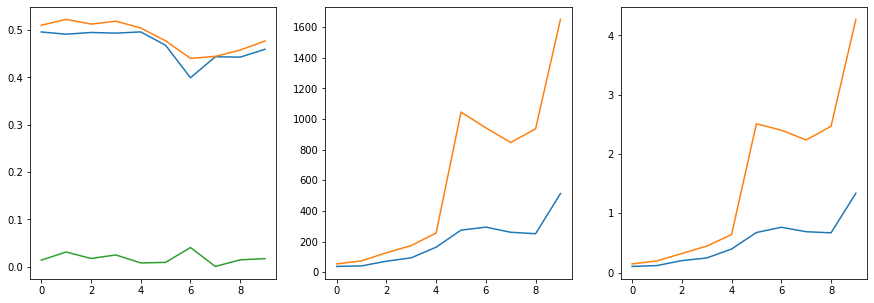

4
0 - 0.01 / 1 - 0.005623413251903491 / 2 - 0.0031622776601683794 / 3 - 0.001778279410038923 / 4 - 0.001 / 5 - 0.0005623413251903491 / 6 - 0.00031622776601683794 / 7 - 0.0001778279410038923 / 8 - 0.00010000000000000002 / 9 - 5.623413251903492e-05 / 


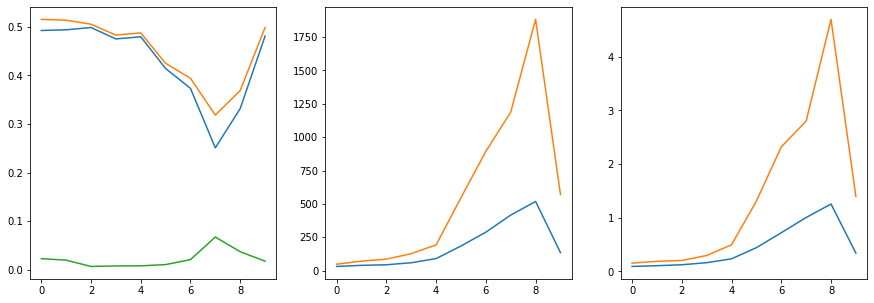

10
0 - 0.01 / 1 - 0.005623413251903491 / 2 - 0.0031622776601683794 / 3 - 0.001778279410038923 / 4 - 0.001 / 5 - 0.0005623413251903491 / 6 - 0.00031622776601683794 / 7 - 0.0001778279410038923 / 8 - 0.00010000000000000002 / 9 - 5.623413251903492e-05 / 


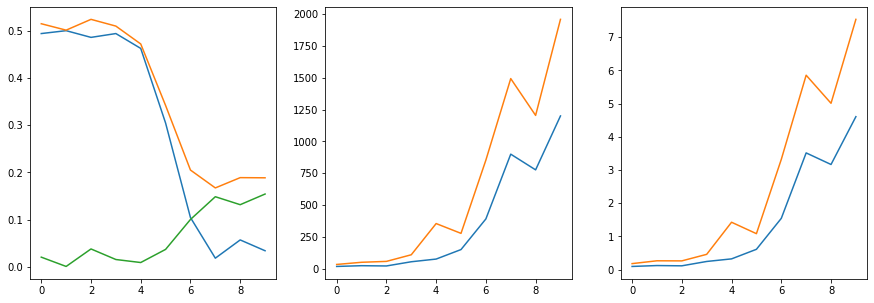

50
0 - 0.01 / 1 - 0.005623413251903491 / 2 - 0.0031622776601683794 / 3 - 0.001778279410038923 / 4 - 0.001 / 5 - 0.0005623413251903491 / 6 - 0.00031622776601683794 / 7 - 0.0001778279410038923 / 8 - 0.00010000000000000002 / 9 - 5.623413251903492e-05 / 


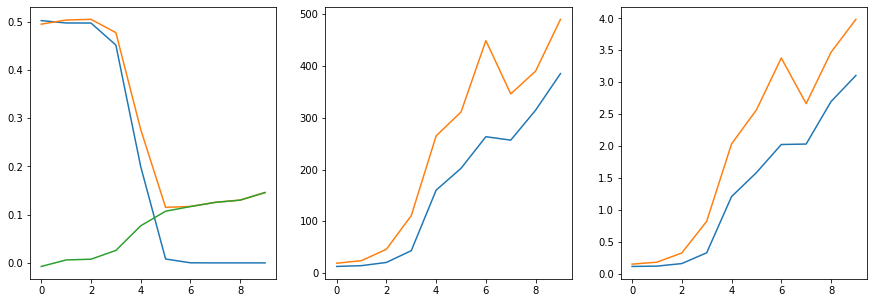

In [7]:
print('2')
validate(dataset, data_labels, 2)
print('4')
validate(dataset, data_labels, 4)
print('10')
validate(dataset, data_labels, 10)
print('50')
validate(dataset, data_labels, 50)

***Analysis:***

After exucating the function with parameters 2, 4, 10, and 50, we can give a better description of what is going on. When we have two nodes on each hidden layer, regardless of the way we train the model, the model isn't performing much better than classifying instances randomly. When the learning rate is greater than 0.001, other executions also suffer from similar problem. 
Another problem is that with 10 or less nodes in each hidden layer, when the learning rate is too small, the number of needed iterations exceeds our limit(1000 iterations).

Beside these two problem, we can see that as the number of nodes increases, we needs less iteration and time and larger learning rate to train a good-enough model. Also the reults show that this model has a better performance in both training and test set.
The last run also shows that when the learning rate is lower than 0.0003, in spite of increase in the number of iteration needed, the trained classifier doesn't have lower train or test error.

## Part 2 (continue)
To find the best parameters for training neural network(learning rate and number of nodes), We continue using validate function with these inputs:

50, 65, 80, 95, 110, 125, 140.

50
0 - 0.01 / 1 - 0.005623413251903491 / 2 - 0.0031622776601683794 / 3 - 0.001778279410038923 / 4 - 0.001 / 5 - 0.0005623413251903491 / 6 - 0.00031622776601683794 / 7 - 0.0001778279410038923 / 8 - 0.00010000000000000002 / 9 - 5.623413251903492e-05 / 


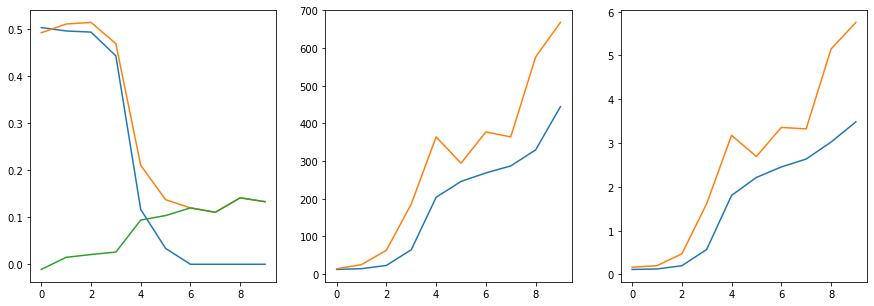

65
0 - 0.01 / 1 - 0.005623413251903491 / 2 - 0.0031622776601683794 / 3 - 0.001778279410038923 / 4 - 0.001 / 5 - 0.0005623413251903491 / 6 - 0.00031622776601683794 / 7 - 0.0001778279410038923 / 8 - 0.00010000000000000002 / 9 - 5.623413251903492e-05 / 


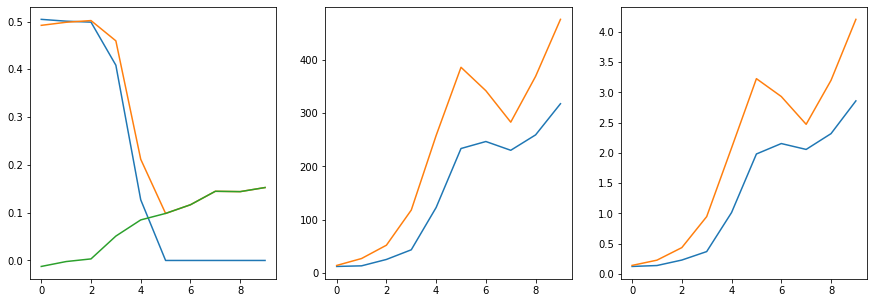

80
0 - 0.01 / 1 - 0.005623413251903491 / 2 - 0.0031622776601683794 / 3 - 0.001778279410038923 / 4 - 0.001 / 5 - 0.0005623413251903491 / 6 - 0.00031622776601683794 / 7 - 0.0001778279410038923 / 8 - 0.00010000000000000002 / 9 - 5.623413251903492e-05 / 


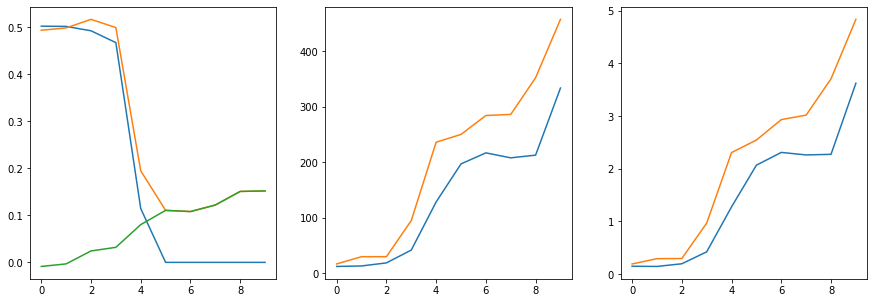

95
0 - 0.01 / 1 - 0.005623413251903491 / 2 - 0.0031622776601683794 / 3 - 0.001778279410038923 / 4 - 0.001 / 5 - 0.0005623413251903491 / 6 - 0.00031622776601683794 / 7 - 0.0001778279410038923 / 8 - 0.00010000000000000002 / 9 - 5.623413251903492e-05 / 


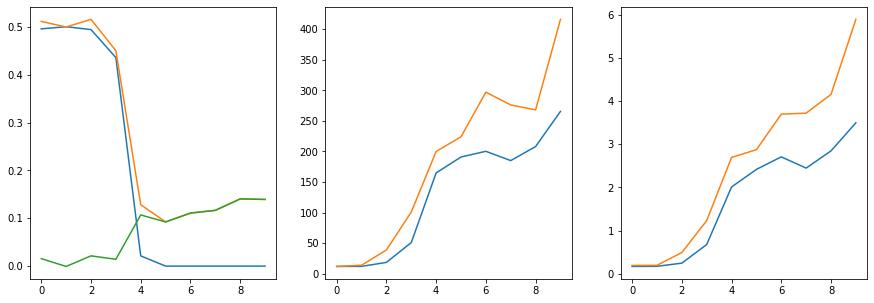

110
0 - 0.01 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


1 - 0.005623413251903491 / 2 - 0.0031622776601683794 / 3 - 0.001778279410038923 / 4 - 0.001 / 5 - 0.0005623413251903491 / 6 - 0.00031622776601683794 / 7 - 0.0001778279410038923 / 8 - 0.00010000000000000002 / 9 - 5.623413251903492e-05 / 


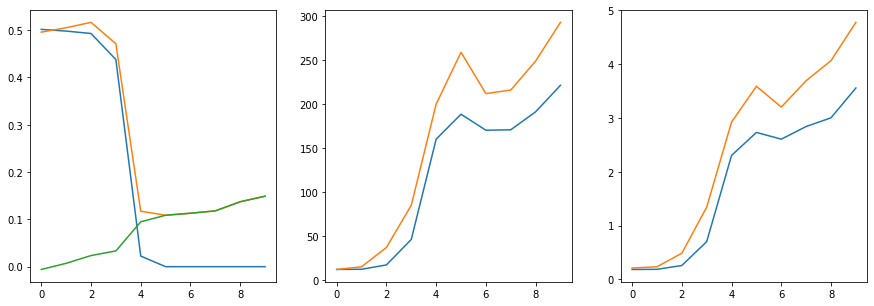

125
0 - 0.01 / 1 - 0.005623413251903491 / 2 - 0.0031622776601683794 / 3 - 0.001778279410038923 / 4 - 0.001 / 5 - 0.0005623413251903491 / 6 - 0.00031622776601683794 / 7 - 0.0001778279410038923 / 8 - 0.00010000000000000002 / 9 - 5.623413251903492e-05 / 


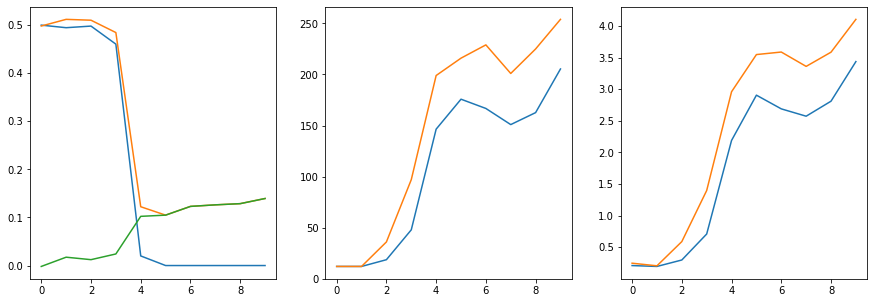

140
0 - 0.01 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


1 - 0.005623413251903491 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


2 - 0.0031622776601683794 / 3 - 0.001778279410038923 / 4 - 0.001 / 5 - 0.0005623413251903491 / 6 - 0.00031622776601683794 / 7 - 0.0001778279410038923 / 8 - 0.00010000000000000002 / 9 - 5.623413251903492e-05 / 


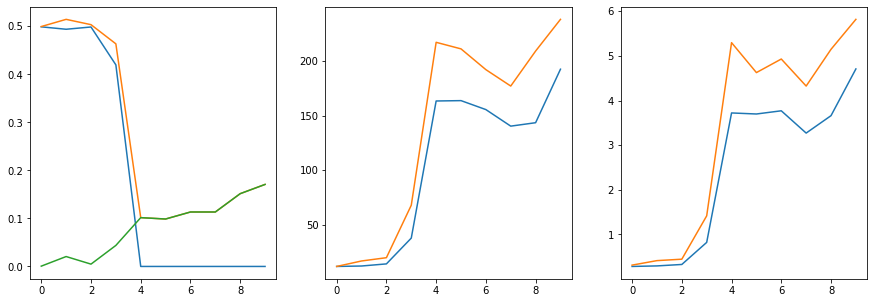

In [8]:
for i in range(50, 155, 15):
    print(str(i))
    validate(dataset, data_labels, i)

***Analysis:***

In all cases above, it is observable that in experiments with a learning rate higher than 0.0005 the trained classifier has no error in the training set. In spite of this fact, we used 0.001 as the learning rate in Part 2 because of two reasons: First, using the amount of 0.0005 needs more training time and more iterations compared to 0.001. Second, with more than 90 nodes in each hidden layer, the training and test error in experiments No.4 and No.5 do not have much difference.

For choosing the appropriate number of nodes, 110 is chosen; because models with 110 nodes have lower error compared to classifiers with less number of nodes and also much shorter training time compared to classifiers with a greater number of nodes.

# Part 5
The last part of the code investigates the effect of the number of layers on the process of classification when the learning rate and the number of nodes in each hidden layer are constant. This experiment is performed with the "validate_layer_num" function which takes the number of nodes in each layer and draws 4 plots exploring the effect with 4 different learning rates: 0.003, 0.001, 0.0003, and 0.0001. After the code, the function is executed with 10, 20, and 50 nodes in each hidden layer.

In [41]:
### part5

def validate_layer_num (dataset, data_labels, node_in_each_layer):
    l, h = 2, 20
    learning_rates = [0.003, 0.001, 0.0003, 0.0001]
    
    init_l = [i for i in range(l, h)]
    
    x = 15
    test_perc = 0.3
    
    figure, axis = plt.subplots(2, 2)
    figure.set_size_inches(15, 10)
    
    for k in range(len(learning_rates)):
        tr_err_l = []
        test_err_l = []
        print("\n", learning_rates[k], end = ": ")
        for i in range(l, h):
            print(i, end = " / ")
            y = list(node_in_each_layer for j in range(i))
            tr_err_list = [0 for i in range(x)]
            test_err_list = [0 for i in range(x)]
            
            for j in range(x):
                trainingset, training_labels, testset, test_labels = devide_into_test_and_train(dataset, data_labels, test_perc, False)
                classifier = build_classifier(trainingset, training_labels, y, learning_rate = learning_rates[k])
                tr_err_list[j], test_err_list[j] = report_error(classifier, trainingset, training_labels, testset, test_labels)

            tr_err_l.append(sum(tr_err_list)/x)
            test_err_l.append(sum(test_err_list)/x)
        
        axis[k//2][k%2].plot(init_l, tr_err_l, init_l, test_err_l)
    
    plt.show()


 0.003: 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 14 / 15 / 16 / 17 / 18 / 19 / 
 0.001: 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 14 / 15 / 16 / 17 / 18 / 19 / 
 0.0003: 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


13 / 14 / 15 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


16 / 17 / 18 / 19 / 
 0.0001: 2 / 3 / 4 / 5 / 6 / 7 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


8 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


9 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


10 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


11 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


12 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and 

13 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


14 / 15 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


16 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


17 / 18 / 19 / 

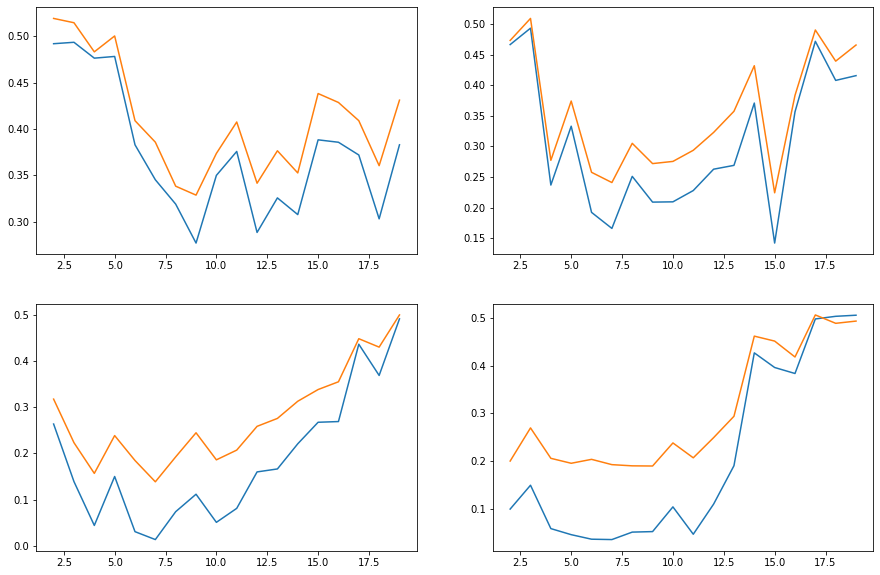

In [44]:
validate_layer_num(dataset, data_labels, 10)


 0.003: 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 14 / 15 / 16 / 17 / 18 / 19 / 
 0.001: 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 14 / 15 / 16 / 17 / 18 / 19 / 
 0.0003: 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 14 / 15 / 16 / 17 / 18 / 19 / 
 0.0001: 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


14 / 15 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


16 / 17 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


18 / 19 / 

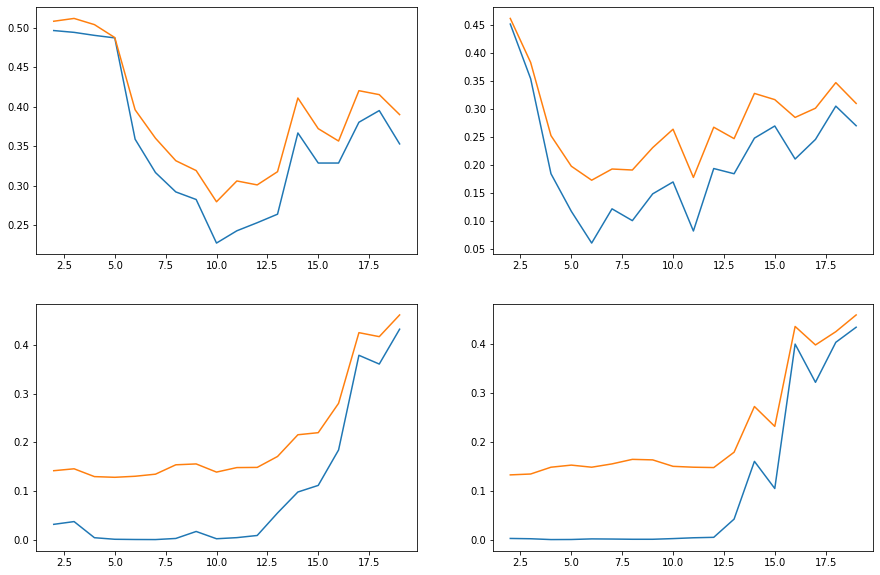

In [42]:
validate_layer_num(dataset, data_labels, 20)


 0.003: 2 / 3 / 4 / 5 / 6 / 

c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\users\padidar\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


7 / 8 / 9 / 10 / 11 / 12 / 13 / 14 / 15 / 16 / 17 / 18 / 19 / 
 0.001: 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 14 / 15 / 16 / 17 / 18 / 19 / 
 0.0003: 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 14 / 15 / 16 / 17 / 18 / 19 / 
 0.0001: 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9 / 10 / 11 / 12 / 13 / 14 / 15 / 16 / 17 / 18 / 19 / 

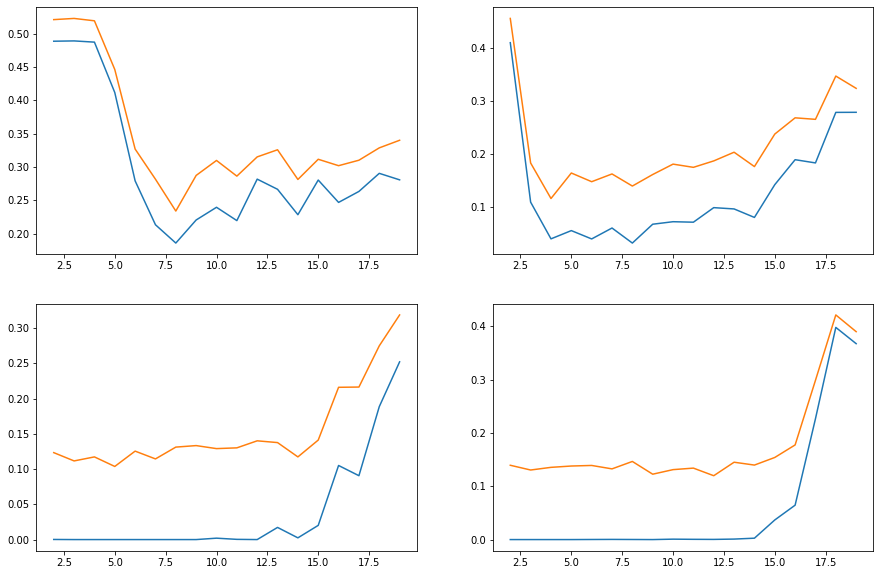

In [43]:
validate_layer_num(dataset, data_labels, 50)

***Analysis:***

In executions of the "validate_layer_num" function, we can observe the training and test error caused in training neural networks with 2 to 20 hidden layers. It is understandable from the plots of each execution that as we decrease the learning rate, networks with greater number of layers show worse performance while those with less layers improve. In all cases, neural networks with 8 to 12 layers show lowest error compared to other networks.

If we look at different execution we can also observe that as we increase the number of nodes, the performance increases whatever the number of layers be. Tough not shown by any plot, we can figure out from the errors that occurred in execution that when we train a model with 10 nodes, we may need more iteration, especially when the learning rate is small.